# Setting up datasets

This file sets up the datasets. It can take some time to run.

Subsequent analyses can just import the CSV files it creates:

1. bbNoText.csv is all of the numerical values, plus the dates. It doesn't include the Beige Books texts. It's a lot smaller file.
2. bbText.csv includes all of the Beige Book texts and the sentiment scores per sentence. It's a larger file.



In [1]:
# Importing pandas for numerical variable analysis and os, numpy, string, and nltk for text variable analysis.

import pandas as pd
import os as os
import numpy as np
import string as string
import nltk
from nltk.corpus import stopwords

In [2]:
# Reading in the data
districtLevels = pd.read_csv('district_coincident_index.csv')

In [3]:
# Converting date column to date-time format
districtLevels['Date'] = pd.to_datetime(districtLevels['Date'])

In [4]:
# Reshape dataframe from wide to long
    # This does it for both the levels and differences from national average
    # Having decided only to use the levels, I have commented out the diffs
districtLongL = pd.melt(districtLevels, id_vars=["Date"], var_name="District", value_name="Value")
#districtLong = pd.melt(districtDiffs, id_vars=["Date", "USPHCI"], var_name="District", value_name="Value")

# Extract the numeric part from the "District" names and convert to integers
districtLongL["District"] = districtLongL["District"].str.extract(r'(\d+)').astype(int)
#districtLong["District"] = districtLong["District"].str.extract(r'(\d+)').astype(int)

# Sort the DataFrame by "Date" and "District" columns
districtLongL = districtLongL.sort_values(by=["Date", "District"])
#districtLong = districtLong.sort_values(by=["Date", "District"])

# Reset the index
districtLongL.reset_index(drop=True, inplace=True)
#districtLong.reset_index(drop=True, inplace=True)


In [5]:
# Define a mapping of city abbreviations to district numbers
city_to_district = {
    "bo": 1,
    "ny": 2,
    "ph": 3,
    "cl": 4,
    "ri": 5,
    "at": 6,
    "ch": 7,
    "sl": 8,
    "mn": 9,
    "kc": 10,
    "da": 11,
    "sf": 12,
}

# Define a mapping of month codes (as named in the original text files of the Beige Books) to month names
month_to_name = {
    "1": "December",
    "2": "October",
    "3": "September",
    "4": "July",
    "5": "June",
    "6": "May",
    "7": "March",
    "8": "January",
}

# Define a mapping of month names to month numbers
name_to_month_numerical = {
    "December": "12",
    "October": "10",
    "September": "09",
    "July": "07",
    "June": "06",
    "May": "05",
    "March": "03",
    "January": "01",
}


In [6]:
# Reading in the Beige Books texts as a dataframe
    # Also including the filename so we can know which region, month, and year it's from

# Setting the directory where the text files of the Beige Books are stored
directory_path = "C:/Users/MCOB PHD 14/Dropbox/Charlie's Dissertation/Beige Books"

# Create empty lists to store text and file names
textDF = []
file_names = []

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
            # Append the text to the text_data list
            textDF.append(file.read())
            # Append the file name to the file_names list
            file_names.append(filename)

# Create a DataFrame from the text and file_names lists
data = {'text': textDF, 'file_name': file_names}
BeigeBookDF = pd.DataFrame(data)

In [7]:
# Import the nltk vader package for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [8]:
# Create the function and run it on the Beige Book dataframe
def analyze_sentiment(BeigeBookDF):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(BeigeBookDF)
    
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        sentiment = 'positive'
    elif compound_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return compound_score, sentiment

BeigeBookDF['compound_score'], BeigeBookDF['sentiment'] = zip(*BeigeBookDF['text'].apply(analyze_sentiment))


In [9]:
# Create a new dataframe that is a copy of BeigeBookDF
bbDF = BeigeBookDF

# Extract the year, city, and month code into separate columns
bbDF[['Year', 'City', 'MonthCode']] = BeigeBookDF['file_name'].str.extract(r'(\d{4})_(\w{2}) \((\d)\).txt')

# Map the city abbreviations to district numbers
bbDF['District'] = bbDF['City'].map(city_to_district)

# Map the month code to month names
bbDF['MonthName'] = bbDF['MonthCode'].map(month_to_name)

# Map the month names to numerical month numbers
bbDF['MonthNumerical'] = bbDF['MonthName'].map(name_to_month_numerical)

# Create a new column with the formatted date
bbDF['Date'] = bbDF['Year'] + '-' + BeigeBookDF['MonthNumerical'] + '-01'

In [10]:
# Convert the 'Date' column to a datetime data type
bbDF['Date'] = pd.to_datetime(bbDF['Date'])

# Use the merge function to join the DataFrames based on the 'Date' and 'District' columns
bbMerged = districtLongL.merge(bbDF, on=['Date', 'District'])

In [11]:
# Rename the Value column to 'econ_index'
bbMerged = bbMerged.rename(columns={'Value': 'econ_index'})

In [12]:
# Mean sentence per Beige Book compound score

from nltk.tokenize import sent_tokenize
sia = SentimentIntensityAnalyzer()

def calculate_sentiment_scores(text):
    sentences = sent_tokenize(text)
    scores = []

    for sentence in sentences:
        sentiment_score = sia.polarity_scores(sentence)
        scores.append(sentiment_score)

    return scores


In [13]:
results = []

for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):  
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r') as file:
            text = file.read()
        
        sentiment_scores = calculate_sentiment_scores(text)
        results.append({
            'File': filename,
            'Sentiment Scores': sentiment_scores
        })


In [14]:
# Going to do the above for every document
    # Going to start with the bbMerged file, which already has Beige Book documents listed by city and date
    # Going to create a new df that drops some of the extra stuff leftover in bbMerged

bbSimple = bbMerged

In [15]:
# Now calculating the compound score for each sentence in each Beige Book
    # Then saving that as a list within the bbSimple dataframe

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate the compound sentiment score
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    compound_scores = [sid.polarity_scores(sentence)['compound'] for sentence in sentences]
    return compound_scores

# Assuming 'bbSimple' is your DataFrame
bbSimple['compound_sentiment'] = bbSimple['text'].apply(calculate_sentiment)


In [16]:
# Example: Calculate the mean and median sentiment scores for each document
# bbSimple['mean_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
# bbSimple['median_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sorted(x)[len(x) // 2] if len(x) > 0 else 0)

bbSimple['mean_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
bbSimple['median_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sorted(x)[len(x) // 2] if len(x) > 0 else 0)

In [17]:
# Doing quartiles as well

import numpy as np

# DbbSimple[['econ_index', 'compound_sentiment', 'mean_sentiment', 'IQR_sentiment']].median()efine a list of desired quartiles (25th, 50th, and 75th percentiles)
quartiles = [25, 50, 75]

# Calculate the specified quartiles for each document
for quartile in quartiles:
    column_name = f'{quartile}th_quartile_sentiment'
    bbSimple[column_name] = bbSimple['compound_sentiment'].apply(lambda x: np.percentile(x, quartile) if len(x) > 0 else 0)


In [18]:
# Calculating interquartile range
bbSimple['IQR_sentiment'] = bbSimple['75th_quartile_sentiment'] - bbSimple['25th_quartile_sentiment']

In [19]:
# Calculate variance of sentiment scores
bbSimple['variance_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: np.var(x) if len(x) > 0 else 0)

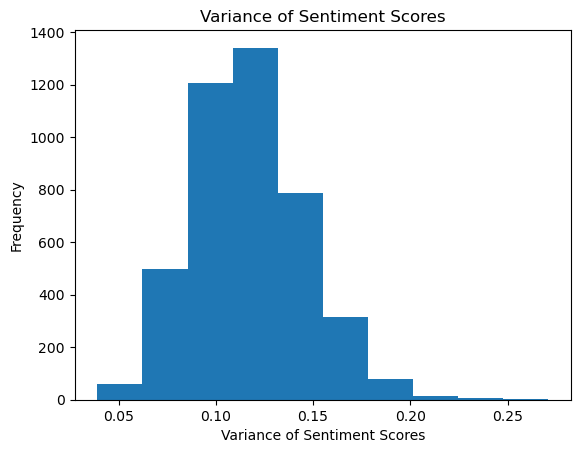

In [22]:
# Plot variance of sentiment scores
import matplotlib.pyplot as plt
plt.hist(bbSimple['variance_sentiment'])
plt.xlabel('Variance of Sentiment Scores')
plt.ylabel('Frequency')
plt.title('Variance of Sentiment Scores')
plt.show()

In [46]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

path = "C:/Users/MCOB PHD 14/Desktop/bbFinal/Data/trigrams.csv"
trigrams = pd.read_csv(path)

In [47]:
# Load NLTK's sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment for a given text
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    compound_score = 0

    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        compound_score += scores['compound']

    average_compound_score = compound_score / len(sentences)
    return average_compound_score

# List to store trigram and sentiment information
trigram_sentiment_list = []


# Loop through each trigram
for _, trigram_row in trigrams.iterrows():
    trigram = trigram_row['trigram']

    # Loop through each document in the subset
    for _, doc_row in bbSimple.iterrows():
        document = doc_row['text']
        date = doc_row['Date']
        district = doc_row['District']
        year = doc_row['Year']
        city = doc_row['City']
        month = doc_row['MonthName']

        # Tokenize the document into sentences
        sentences = sent_tokenize(document)

        # Check if the trigram is present in any sentence
        for sentence_index, sentence in enumerate(sentences):
            if trigram in sentence:
                # Extract the surrounding two sentences
                trigram_index = sentence_index
                start_index = max(0, trigram_index - 1)
                end_index = min(len(sentences), trigram_index + 2)
                context_sentences = sentences[start_index:end_index]

                # Join the sentences to form a paragraph
                context_paragraph = ' '.join(context_sentences)

                # Calculate sentiment for the extracted context
                sentiment_score = calculate_sentiment(context_paragraph)

                # Append trigram, sentiment, and context to the list
                trigram_sentiment_list.append({
                    'Trigram': trigram,
                    'Sentiment': sentiment_score,
                    'Context': context_paragraph,
                    'Document': document,
                    'Date': date,
                    'District': district,
                    'Year': year,
                    'City': city,
                    'Month': month
                })

# Create a DataFrame from the list of dictionaries
result_df3 = pd.DataFrame(trigram_sentiment_list)

# Export the DataFrame to a CSV file in the default working directory
#result_df3.to_csv('trigram_sentiment_results.csv', index=False)

# Display a message indicating the export is successful
#print('DataFrame successfully exported to trigram_sentiment_results.csv in the default working directory.')


In [48]:
# Mean of each trigram's sentiment + all other trigrams' sentiment found in a document
    # Some documents don't have any Trigrams; some have multiple
mean_sentiments = result_df3.groupby(['Document'])['Sentiment'].mean().reset_index()


In [49]:
# Rename the 'Sentiment' column to 'Sentiment_Trigram'
mean_sentiments = mean_sentiments.rename(columns={'Sentiment': 'sentiment_trigram'})


In [50]:
# Merge mean_sentiments back to bbSimple based on the common columns 'text' and 'Document'
bbTri = pd.merge(bbSimple, mean_sentiments, left_on='text', right_on='Document', how='left')

# Drop the duplicate 'Document' column, which is now redundant
bbTri = bbTri.drop('Document', axis=1)

# Set N/As to equal zero
bbTri['sentiment_trigram'] = bbTri['sentiment_trigram'].fillna(0)

In [51]:
# want to create a DV that's percent change in econ_index_levels

bbTri.sort_values(by=['District', 'Date'], inplace=True)
bbTri['econ_index_change'] = bbTri.groupby('District')['econ_index'].pct_change() *100

# Now want to create a new dummy that equals 1 if the change is positive
bbTri['econ_index_change_dummy'] = (bbTri['econ_index_change'] > 0).astype(int)

In [52]:
bbNoText = bbTri[['file_name', 'Date', 'Year', 'District', 'econ_index', 'econ_index_change', 'econ_index_change_dummy', 'compound_score', 'mean_sentiment', 'median_sentiment', 'IQR_sentiment', 'sentiment_trigram']]

In [53]:
# Export the DataFrame to a CSV file in the default working directory
bbNoText.to_csv('bbNoText.csv', index=False)

In [54]:
# Export bbTri, which has the full text included and sentence level compound scores (calculated with VADER)
bbTri.to_csv('bbText.csv', index=False)